In [1]:
%matplotlib inline
import csv
import gzip
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
validation_file = "mc3.v0.2.8.validated.maf.gz"

In [3]:
somatic_data = []
germline_data = []
none_data = []
callers = set()
filters = set()
with gzip.GzipFile(validation_file) as handle:
    reader = csv.DictReader(handle, delimiter="\t")
    for row in reader:
        if row["VALIDATION_STATUS"] == "Somatic":
            somatic_data.append(row)
        elif row["VALIDATION_STATUS"] == "Germline":
            germline_data.append(row)
        elif row["VALIDATION_STATUS"] == "None":
            none_data.append(row)
        else:
            raise Exception("Weird Data")
        for i in row["CENTERS"].split("|"):
            callers.add(i.replace("*", ""))
        for i in row["FILTER"].split(","):
            filters.add(i)

In [4]:
def filter_center_count(rows, count):
    o = []
    for r in rows:
        if len(r["CENTERS"].split("|")) >= count:
            o.append(r)
    return o

([<matplotlib.patches.Wedge at 0x1310f4190>,
  <matplotlib.text.Text at 0x131117990>])

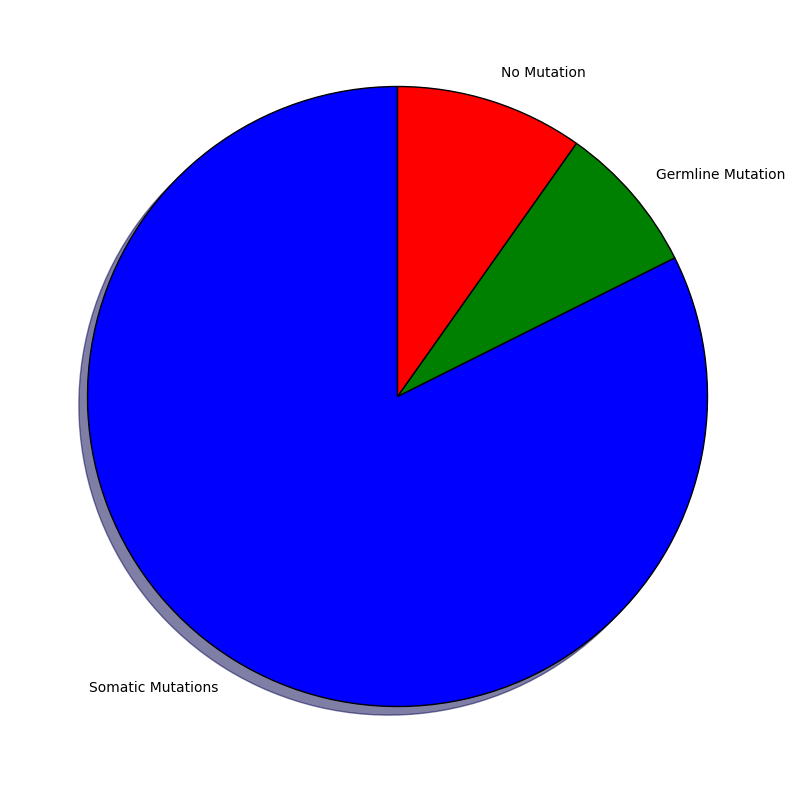

In [5]:
c = 2
plt.figure(figsize=(10,10))
plt.pie( [
    len(filter_center_count(somatic_data,c)), 
    len(filter_center_count(germline_data,2)),
    len(filter_center_count(none_data,2))], 
    labels=["Somatic Mutations", "Germline Mutation", "No Mutation"], shadow=True, startangle=90 )

In [6]:
range(1,6)

[1, 2, 3, 4, 5]

In [7]:
somatic_counts = []
germline_counts = []
none_counts = []
for i in range(1, 6):
    somatic_counts.append( len(filter_center_count(somatic_data,i)) )
    germline_counts.append( len(filter_center_count(germline_data,i)) )
    none_counts.append( len(filter_center_count(none_data,i)) )
somatic_counts = np.array(somatic_counts)
germline_count = np.array(germline_counts)
none_counts = np.array(none_counts)

In [8]:
ind = np.arange(5) 

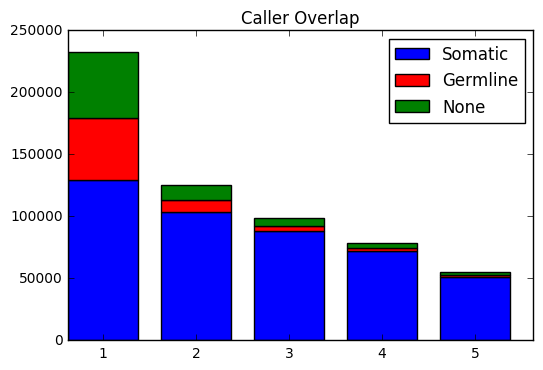

In [9]:
width = 0.75
plt.title('Caller Overlap')
p1 = plt.bar(ind, somatic_counts, width)
p2 = plt.bar(ind, germline_counts, width, bottom=somatic_counts, color="r")
p3 = plt.bar(ind, none_counts, width, bottom=somatic_counts + germline_counts, color="g")
plt.xticks(ind + width/2., ('1', '2', '3', '4', '5'))
plt.legend((p1[0], p2[0], p3[0]), ('Somatic', 'Germline', "None"))
plt.show()

In [10]:
def filter_center_and_filter(rows, caller, filter):
    o = []
    for r in rows:
        if r["CENTERS"].count(caller) and r["FILTER"].count(filter):
            o.append(r)
    return o

In [11]:
print len(filter_center_and_filter(somatic_data, "MUTECT", "PASS"))

67491


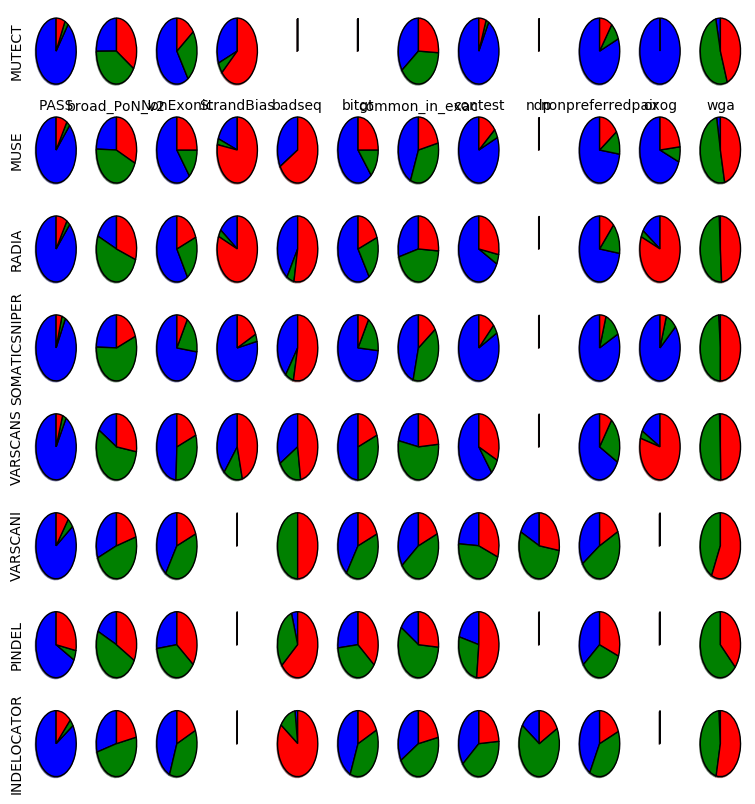

In [12]:
plt.figure(figsize=(10,10))

caller_order = [
    'MUTECT',
    'MUSE',
    'RADIA',
    'SOMATICSNIPER',
    'VARSCANS',
    'VARSCANI',
    'PINDEL',
    'INDELOCATOR'
]

filter_order = [
    'PASS',
    'broad_PoN_v2',
    'NonExonic',
    'StrandBias',
    'badseq',
    'bitgt',
    'common_in_exac',
    'contest',
    'ndp',
    'nonpreferredpair',
    'oxog',
    'wga'
]

for i, caller in enumerate(caller_order):
    for j, filter in enumerate(filter_order):
        plt.subplot(len(callers), len(filters), i*len(filters) + j + 1 )
        if j == 0:
            plt.ylabel(caller)
        if i == 0:
            plt.xlabel(filter)            
        plt.pie( [
            len(filter_center_and_filter(somatic_data,caller,filter)), 
            len(filter_center_and_filter(germline_data,caller,filter)),
            len(filter_center_and_filter(none_data,caller,filter))], 
            shadow=True, startangle=90 )
plt.show()


In [13]:
for i in range(10):
    if somatic_data[i]["VARIANT_CLASS"] == "SNV":
        a = somatic_data[i]["CONTEXT"]
        b = [somatic_data[i]["Match_Norm_Seq_Allele1"], somatic_data[i]["Match_Norm_Seq_Allele2"]]
        c = [somatic_data[i]["Tumor_Seq_Allele1"],somatic_data[i]["Tumor_Seq_Allele2"]]
        print a, a[len(a)/2],b,c

CCACACGACGG C ['C', 'C'] ['C', 'T']
TTACTATGGGA A ['A', 'A'] ['A', 'C']
CTTTCCGTTAT C ['C', 'C'] ['C', 'T']
AAACACGCACC C ['C', 'C'] ['C', 'T']
CATGACGACCT C ['C', 'C'] ['C', 'T']
TCTGGAAGATG A ['A', 'A'] ['A', 'G']
CGCCAGGCAGC G ['G', 'G'] ['G', 'C']
CGCCAGGCAGC G ['G', 'G'] ['G', 'C']
GCCTCCGGTTC C ['C', 'C'] ['C', 'T']


In [14]:
def get_tri_count(rows):
    tri_count = {}
    for row in rows:
        if row["VARIANT_CLASS"] == "SNV":
            a = row["CONTEXT"]
            b = row["Tumor_Seq_Allele2"]
            tri = a[ (len(a)/2)-1: (len(a)/2)+2]
            if tri not in tri_count:
                tri_count[tri] = {}
            tri_count[tri][b] = tri_count[tri].get(b,0) + 1
    return tri_count

In [15]:
print get_tri_count(somatic_data)

{'ACC': {'A': 498, 'T': 556, 'G': 191}, 'ATG': {'A': 223, 'C': 623, 'G': 105}, 'ACA': {'A': 489, 'T': 685, 'G': 219}, 'ACG': {'A': 204, 'T': 2958, 'G': 127}, 'ATC': {'A': 187, 'C': 279, 'G': 74}, 'AAC': {'C': 263, 'T': 131, 'G': 251}, 'ATA': {'A': 112, 'C': 550, 'G': 82}, 'AGG': {'A': 684, 'C': 295, 'T': 887}, 'CCT': {'A': 927, 'T': 689, 'G': 299}, 'CTC': {'A': 244, 'C': 369, 'G': 141}, 'AGC': {'A': 804, 'C': 195, 'T': 438}, 'TTT': {'A': 189, 'C': 385, 'G': 383}, 'AGA': {'A': 1689, 'C': 2304, 'T': 801}, 'CAT': {'C': 105, 'T': 257, 'G': 617}, 'AAT': {'C': 165, 'T': 235, 'G': 427}, 'ATT': {'A': 251, 'C': 400, 'G': 184}, 'CTG': {'A': 307, 'C': 662, 'G': 208}, 'CTA': {'A': 100, 'C': 235, 'G': 60}, 'ACT': {'A': 298, 'T': 429, 'G': 246}, 'CAC': {'C': 91, 'T': 432, 'G': 349}, 'AAA': {'C': 329, 'T': 222, 'G': 357}, 'CCG': {'A': 378, 'T': 2703, 'G': 158}, 'AGT': {'A': 416, 'C': 221, 'T': 338}, 'CCA': {'A': 722, 'T': 727, 'G': 222}, 'CAA': {'C': 145, 'T': 94, 'G': 249}, 'CCC': {'A': 674, 'T': 64

In [16]:
color_map = {
    "A" : "lightblue",
    "C" : "cornflowerblue",
    "G" : "royalblue",
    "T" : "navy"
}
nuc_num = {
    "A" : 0,
    "C" : 1,
    "G" : 2,
    "T" : 3
}

def nuc_map(l):
    o = []
    for i in l:
        o.append(nuc_num[i])
    return o

[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]


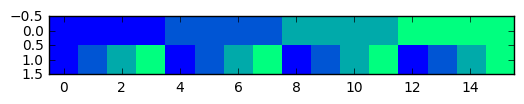

In [17]:
nuc = ['A','C','G','T']
x = [ nuc_map(sum(list([n]*4 for n in nuc), [])), nuc_map(nuc * 4) ]
print x
plt.imshow(x, cmap="winter", interpolation="nearest")

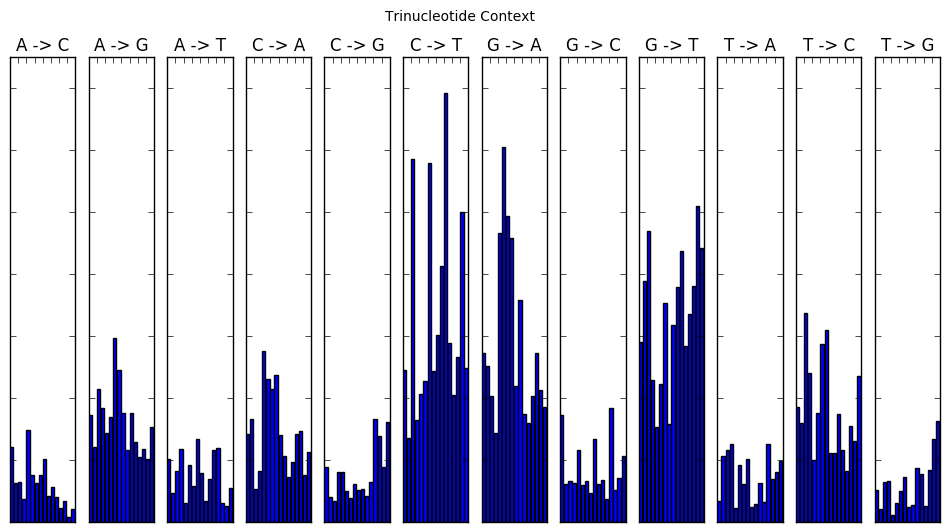

In [18]:
fp_total = float(len(germline_data) + len(none_data))
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(12, 6))
fig.suptitle("Trinucleotide Context")
pane = 0
tri_nuc_max = 0.015
for n1 in nuc:
    for n2 in nuc:
        if n1 != n2:
            tri_somatic = get_tri_count(germline_data + none_data)
            start_nuc = n1
            end_nuc = n2
            o = []
            for a in zip( sum(list([n]*4 for n in nuc), []), nuc * 4 ):
                s = "%s%s%s" % (a[0], start_nuc, a[1])
                o.append(tri_somatic[s][end_nuc] / fp_total)
            axes[pane].bar(range(len(o)), o)
            axes[pane].set_ylim([0,tri_nuc_max])
            axes[pane].set_title("%s -> %s" % (n1, n2))
            axes[pane].set_yticklabels([])
            axes[pane].set_xticklabels([])
            pane += 1

In [19]:
import pyupset as pyu
import pandas

In [20]:
pandas.DataFrame( ["1", "2", "3"] )

,0
0,1
1,2
2,3


{'additional': [],
 'base_set_size': <matplotlib.axes._subplots.AxesSubplot at 0x133b5de50>,
 'figure': <matplotlib.figure.Figure at 0x133e76d90>,
 'intersection_bars': <matplotlib.axes._subplots.AxesSubplot at 0x1334e8790>,
 'intersection_matrix': <matplotlib.axes._subplots.AxesSubplot at 0x1341821d0>,
 'names': <matplotlib.axes._subplots.AxesSubplot at 0x134070fd0>}

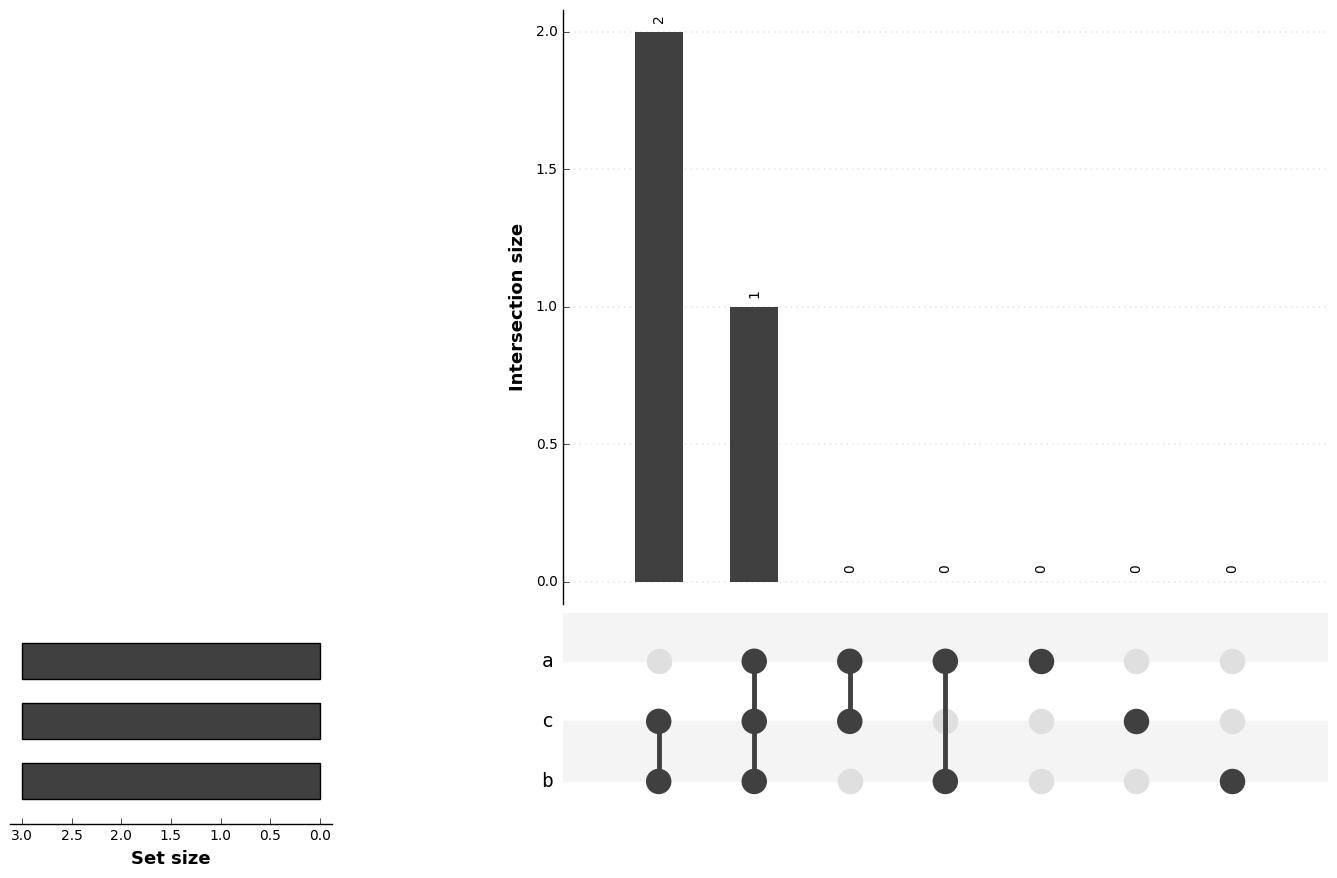

In [28]:
pyu.plot(
    {
        "a" : pandas.DataFrame( {"1", "1", "1"] ),
        "b" : pandas.DataFrame( ["1", "0", "0"] ),
        "c" : pandas.DataFrame( ["0", "0", "1"] )
    }
)

In [42]:
def line2vector(line):
    out = {}
    for c in ['MUTECT', 'MUSE', 'RADIA', 'SOMATICSNIPER', 'VARSCANS', 'VARSCANI', 'PINDEL', 'INDELOCATOR']:
        out[c] = int(c in line['CENTERS'])
    return out

In [51]:
learning_data = pandas.DataFrame(
    list(dict(line2vector(a), status="germline") for a in germline_data) +
    list(dict(line2vector(a), status="somatic") for a in somatic_data) +
    list(dict(line2vector(a), status="none") for a in none_data)
)

In [76]:
from sklearn import linear_model, model_selection, metrics

In [77]:
features = learning_data.drop("status", 1)
labels = learning_data["status"].replace(["none", "germline"], 0).replace("somatic", 1)

0.854506149405 [(0.31810836914872881, 'INDELOCATOR'), (0.36146982716749143, 'MUSE'), (0.25221410427125213, 'MUTECT'), (0.16545891642749214, 'PINDEL'), (0.1151306555292517, 'RADIA'), (0.076783979323472279, 'SOMATICSNIPER'), (0.33691266524866254, 'VARSCANI'), (0.15650669463738914, 'VARSCANS')]
0.857906098832 [(0.31702192456592637, 'INDELOCATOR'), (0.36211995741139164, 'MUSE'), (0.2511397407225312, 'MUTECT'), (0.16521215759494473, 'PINDEL'), (0.11443523208243231, 'RADIA'), (0.077669704905987264, 'SOMATICSNIPER'), (0.33522706471547575, 'VARSCANI'), (0.15511577070312088, 'VARSCANS')]
0.85940131959 [(0.31840079769621404, 'INDELOCATOR'), (0.36188124434666136, 'MUSE'), (0.25208488565004367, 'MUTECT'), (0.16555561808024666, 'PINDEL'), (0.11330832714235352, 'RADIA'), (0.076945672741157378, 'SOMATICSNIPER'), (0.33451036342970808, 'VARSCANI'), (0.15643718042443477, 'VARSCANS')]
0.858572966706 [(0.31768057084654422, 'INDELOCATOR'), (0.36171625029379029, 'MUSE'), (0.25257451079999227, 'MUTECT'), (0.

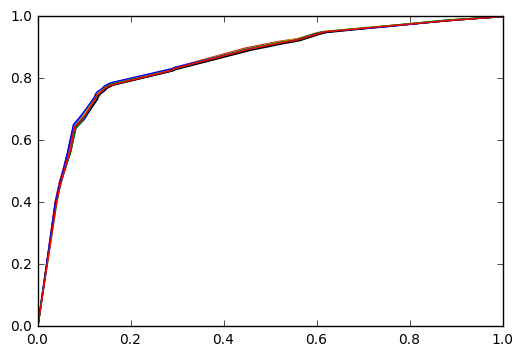

In [86]:
fold = model_selection.KFold(10, shuffle=True)
for train_index, test_index in fold.split(features):
    features_train = features.loc[features.index[train_index]]
    labels_train = labels.loc[labels.index[train_index]]
    features_test = features.loc[features.index[test_index]]
    labels_test = labels.loc[labels.index[test_index]]
    
    model = linear_model.LinearRegression()
    model.fit(features_train, labels_train)
    
    pred = model.predict(features_test)
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred, pos_label=1)
    print metrics.auc(fpr, tpr), zip(model.coef_, features_test.columns)
    plt.plot(fpr, tpr)

In [69]:
model.coef_

array([[ 1.58415506,  1.75221928,  1.52139702,  0.8447799 ,  0.59834235,
         0.68032222,  1.74193593,  0.80057861]])

In [71]:
features.columns

Index([u'INDELOCATOR', u'MUSE', u'MUTECT', u'PINDEL', u'RADIA',
       u'SOMATICSNIPER', u'VARSCANI', u'VARSCANS'],
      dtype='object')